# Project: Correspondence between adult and child longevity and sanitation

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

Gapminder was chosen for this data analysis. This set has information about indicators including but not limited to:
- Economics
- Population
- Work
- Infrastructure
- Health

And much more could be investigated by this dataset. For the purpose of this project, health and infrastructure data were chosen to investigate. Three variables related to health were chosen, male life expectancy, female life expectancy, and child mortality. Then, one infrastructure parameter was chosen, overall sanitation. The goal of this project is to investigate the correlation between sanitation and these three variables. After downloading the data, overall sanitation dataset was found out to cover data only for 2000 to 2017. Contrarily, child mortality covers 1800 to 2100, and both life expectancy sets cover 1950 to 2099. Therefore, only the period 2000 to 2017 has been chosen for investigation for all datasets. The project analyzes the three following questions: 
- Question 1: how does sanitation change over the years?
- Question 2: how does each set change with sanitation?
- Question 3: how does difference between male and female expectancy go?

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline


<a id='wrangling'></a>
## Data Wrangling


## Gathering

In [199]:
child = pd.read_csv('child_mortality_0_5_year_olds_dying_per_1000_born.csv')
male = pd.read_csv('life_expectancy_male.csv')
female = pd.read_csv('life_expectancy_female.csv')
sanitation = pd.read_csv('at_least_basic_sanitation_overall_access_percent.csv')

In [200]:
#checking that columns are object type
child.columns

Index(['country', '1800', '1801', '1802', '1803', '1804', '1805', '1806',
       '1807', '1808',
       ...
       '2091', '2092', '2093', '2094', '2095', '2096', '2097', '2098', '2099',
       '2100'],
      dtype='object', length=302)

In [201]:
male.columns

Index(['country', '1950', '1951', '1952', '1953', '1954', '1955', '1956',
       '1957', '1958',
       ...
       '2090', '2091', '2092', '2093', '2094', '2095', '2096', '2097', '2098',
       '2099'],
      dtype='object', length=151)

In [202]:
female.columns

Index(['country', '1950', '1951', '1952', '1953', '1954', '1955', '1956',
       '1957', '1958',
       ...
       '2090', '2091', '2092', '2093', '2094', '2095', '2096', '2097', '2098',
       '2099'],
      dtype='object', length=151)

In [203]:
sanitation.columns

Index(['country', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017'],
      dtype='object')

In [204]:
# a list for numbers 2000-2017
chosen = []
for i in range(2000,2018):
    i = str(i)
    chosen.append(i)
chosen.append('country')

In [205]:
# A function to cut all unchosen columns since the process repeats
def column_cut(df):
    for column in df:
        if column not in chosen:
            df.drop(columns = column, inplace = True)
    return df

In [206]:
#dropping all other columns in child
column_cut(child)

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,129.00,125.00,121.00,117.00,113.00,109.00,104.00,100.00,96.00,91.90,88.00,84.10,80.50,77.00,73.50,70.40,67.50,64.70
1,Angola,206.00,200.00,193.00,185.00,176.00,167.00,157.00,148.00,138.00,129.00,120.00,113.00,105.00,98.40,92.90,88.10,84.00,80.40
2,Albania,25.90,24.50,23.10,21.80,20.40,19.20,17.90,16.70,15.50,14.40,13.30,12.30,11.40,10.70,10.10,9.60,9.27,9.02
3,Andorra,6.41,6.16,5.93,5.71,5.49,5.27,5.05,4.84,4.62,4.39,4.18,3.98,3.79,3.61,3.43,3.27,3.14,3.01
4,United Arab Emirates,11.20,10.90,10.60,10.30,10.00,9.73,9.44,9.18,8.93,8.69,8.48,8.28,8.13,8.00,7.91,7.83,7.76,7.68
5,Argentina,19.60,18.90,18.30,17.70,17.10,16.50,16.10,15.70,15.30,14.90,14.40,13.90,13.30,12.70,12.10,11.50,10.90,10.40
6,Armenia,30.80,29.30,27.80,26.50,25.20,23.90,22.70,21.60,20.50,19.50,18.50,17.60,16.70,15.90,15.10,14.40,13.70,13.00
7,Antigua and Barbuda,15.80,15.10,14.40,13.70,13.10,12.50,11.90,11.30,10.80,10.20,9.59,9.04,8.52,8.04,7.64,7.29,6.97,6.69
8,Australia,6.19,6.08,5.99,5.91,5.82,5.72,5.59,5.41,5.21,4.99,4.77,4.54,4.32,4.13,3.98,3.87,3.79,3.74
9,Austria,5.50,5.41,5.31,5.20,5.05,4.90,4.76,4.65,4.54,4.44,4.33,4.20,4.05,3.91,3.80,3.71,3.65,3.58


In [207]:
child

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,129.00,125.00,121.00,117.00,113.00,109.00,104.00,100.00,96.00,91.90,88.00,84.10,80.50,77.00,73.50,70.40,67.50,64.70
1,Angola,206.00,200.00,193.00,185.00,176.00,167.00,157.00,148.00,138.00,129.00,120.00,113.00,105.00,98.40,92.90,88.10,84.00,80.40
2,Albania,25.90,24.50,23.10,21.80,20.40,19.20,17.90,16.70,15.50,14.40,13.30,12.30,11.40,10.70,10.10,9.60,9.27,9.02
3,Andorra,6.41,6.16,5.93,5.71,5.49,5.27,5.05,4.84,4.62,4.39,4.18,3.98,3.79,3.61,3.43,3.27,3.14,3.01
4,United Arab Emirates,11.20,10.90,10.60,10.30,10.00,9.73,9.44,9.18,8.93,8.69,8.48,8.28,8.13,8.00,7.91,7.83,7.76,7.68
5,Argentina,19.60,18.90,18.30,17.70,17.10,16.50,16.10,15.70,15.30,14.90,14.40,13.90,13.30,12.70,12.10,11.50,10.90,10.40
6,Armenia,30.80,29.30,27.80,26.50,25.20,23.90,22.70,21.60,20.50,19.50,18.50,17.60,16.70,15.90,15.10,14.40,13.70,13.00
7,Antigua and Barbuda,15.80,15.10,14.40,13.70,13.10,12.50,11.90,11.30,10.80,10.20,9.59,9.04,8.52,8.04,7.64,7.29,6.97,6.69
8,Australia,6.19,6.08,5.99,5.91,5.82,5.72,5.59,5.41,5.21,4.99,4.77,4.54,4.32,4.13,3.98,3.87,3.79,3.74
9,Austria,5.50,5.41,5.31,5.20,5.05,4.90,4.76,4.65,4.54,4.44,4.33,4.20,4.05,3.91,3.80,3.71,3.65,3.58


In [208]:
#repeating the process form male and female
column_cut(male)

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,71.3,71.4,71.5,71.6,71.7,71.8,72.0,72.1,72.2,72.4,72.5,72.7,72.8,72.9,73.1,73.2,73.3,73.5
1,Afghanistan,54.7,55.1,55.6,56.1,56.5,57.0,57.6,58.1,58.6,59.2,59.7,60.2,60.7,61.1,61.6,62.0,62.3,62.7
2,Angola,44.5,45.0,45.6,46.3,47.0,47.9,48.8,49.8,50.8,51.9,52.8,53.8,54.7,55.4,56.1,56.7,57.2,57.7
3,Albania,71.2,71.6,72.0,72.2,72.5,72.7,72.9,73.2,73.4,73.8,74.1,74.6,75.0,75.4,75.7,76.1,76.4,76.6
4,United Arab Emirates,73.5,73.7,74.0,74.2,74.4,74.6,74.8,75.0,75.2,75.4,75.6,75.8,76.0,76.2,76.4,76.6,76.8,77.0
5,Argentina,70.1,70.3,70.5,70.7,70.8,71.0,71.2,71.3,71.5,71.7,71.8,72.0,72.2,72.3,72.5,72.6,72.8,72.9
6,Armenia,68.1,68.5,68.8,69.1,69.2,69.3,69.4,69.5,69.6,69.8,70.0,70.2,70.4,70.6,70.8,70.9,71.0,71.1
7,Antigua and Barbuda,72.4,72.7,72.9,73.1,73.4,73.6,73.8,74.0,74.1,74.3,74.4,74.6,74.7,74.9,75.1,75.2,75.4,75.6
8,Australia,76.9,77.3,77.6,77.9,78.3,78.6,78.8,79.1,79.3,79.5,79.8,80.0,80.2,80.4,80.6,80.8,80.9,81.1
9,Austria,75.1,75.4,75.7,76.1,76.4,76.6,76.9,77.2,77.4,77.7,77.9,78.1,78.3,78.4,78.5,78.6,78.7,78.9


In [209]:
male

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,71.3,71.4,71.5,71.6,71.7,71.8,72.0,72.1,72.2,72.4,72.5,72.7,72.8,72.9,73.1,73.2,73.3,73.5
1,Afghanistan,54.7,55.1,55.6,56.1,56.5,57.0,57.6,58.1,58.6,59.2,59.7,60.2,60.7,61.1,61.6,62.0,62.3,62.7
2,Angola,44.5,45.0,45.6,46.3,47.0,47.9,48.8,49.8,50.8,51.9,52.8,53.8,54.7,55.4,56.1,56.7,57.2,57.7
3,Albania,71.2,71.6,72.0,72.2,72.5,72.7,72.9,73.2,73.4,73.8,74.1,74.6,75.0,75.4,75.7,76.1,76.4,76.6
4,United Arab Emirates,73.5,73.7,74.0,74.2,74.4,74.6,74.8,75.0,75.2,75.4,75.6,75.8,76.0,76.2,76.4,76.6,76.8,77.0
5,Argentina,70.1,70.3,70.5,70.7,70.8,71.0,71.2,71.3,71.5,71.7,71.8,72.0,72.2,72.3,72.5,72.6,72.8,72.9
6,Armenia,68.1,68.5,68.8,69.1,69.2,69.3,69.4,69.5,69.6,69.8,70.0,70.2,70.4,70.6,70.8,70.9,71.0,71.1
7,Antigua and Barbuda,72.4,72.7,72.9,73.1,73.4,73.6,73.8,74.0,74.1,74.3,74.4,74.6,74.7,74.9,75.1,75.2,75.4,75.6
8,Australia,76.9,77.3,77.6,77.9,78.3,78.6,78.8,79.1,79.3,79.5,79.8,80.0,80.2,80.4,80.6,80.8,80.9,81.1
9,Austria,75.1,75.4,75.7,76.1,76.4,76.6,76.9,77.2,77.4,77.7,77.9,78.1,78.3,78.4,78.5,78.6,78.7,78.9


In [210]:
column_cut(female)

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,76.3,76.3,76.4,76.5,76.6,76.7,76.8,77.0,77.1,77.3,77.4,77.6,77.7,77.8,78.0,78.1,78.2,78.4
1,Afghanistan,57.1,57.6,58.1,58.6,59.1,59.6,60.2,60.8,61.3,61.9,62.5,63.0,63.5,64.0,64.5,64.9,65.3,65.7
2,Angola,48.7,49.3,50.0,50.8,51.7,52.6,53.6,54.7,55.8,57.0,58.0,59.1,60.0,60.8,61.6,62.2,62.8,63.3
3,Albania,77.0,77.3,77.5,77.8,78.0,78.2,78.3,78.6,78.8,79.0,79.3,79.6,79.8,79.9,80.0,80.1,80.1,80.1
4,United Arab Emirates,75.7,76.0,76.2,76.4,76.6,76.8,77.0,77.2,77.4,77.6,77.8,78.0,78.1,78.3,78.5,78.7,78.8,79.0
5,Argentina,77.0,77.2,77.3,77.5,77.7,77.8,78.0,78.2,78.3,78.5,78.6,78.8,79.0,79.1,79.3,79.4,79.6,79.7
6,Armenia,74.5,74.8,75.1,75.3,75.5,75.6,75.8,75.9,76.0,76.2,76.4,76.6,76.9,77.2,77.4,77.7,77.9,78.2
7,Antigua and Barbuda,75.4,75.6,75.8,76.0,76.2,76.3,76.5,76.7,76.8,77.0,77.1,77.2,77.4,77.5,77.6,77.7,77.8,77.9
8,Australia,82.3,82.5,82.7,82.9,83.1,83.3,83.5,83.7,83.8,84.0,84.1,84.3,84.4,84.5,84.7,84.8,85.0,85.1
9,Austria,81.1,81.4,81.6,81.8,82.1,82.3,82.5,82.7,82.9,83.0,83.2,83.3,83.4,83.5,83.6,83.6,83.7,83.7


In [211]:
female

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,76.3,76.3,76.4,76.5,76.6,76.7,76.8,77.0,77.1,77.3,77.4,77.6,77.7,77.8,78.0,78.1,78.2,78.4
1,Afghanistan,57.1,57.6,58.1,58.6,59.1,59.6,60.2,60.8,61.3,61.9,62.5,63.0,63.5,64.0,64.5,64.9,65.3,65.7
2,Angola,48.7,49.3,50.0,50.8,51.7,52.6,53.6,54.7,55.8,57.0,58.0,59.1,60.0,60.8,61.6,62.2,62.8,63.3
3,Albania,77.0,77.3,77.5,77.8,78.0,78.2,78.3,78.6,78.8,79.0,79.3,79.6,79.8,79.9,80.0,80.1,80.1,80.1
4,United Arab Emirates,75.7,76.0,76.2,76.4,76.6,76.8,77.0,77.2,77.4,77.6,77.8,78.0,78.1,78.3,78.5,78.7,78.8,79.0
5,Argentina,77.0,77.2,77.3,77.5,77.7,77.8,78.0,78.2,78.3,78.5,78.6,78.8,79.0,79.1,79.3,79.4,79.6,79.7
6,Armenia,74.5,74.8,75.1,75.3,75.5,75.6,75.8,75.9,76.0,76.2,76.4,76.6,76.9,77.2,77.4,77.7,77.9,78.2
7,Antigua and Barbuda,75.4,75.6,75.8,76.0,76.2,76.3,76.5,76.7,76.8,77.0,77.1,77.2,77.4,77.5,77.6,77.7,77.8,77.9
8,Australia,82.3,82.5,82.7,82.9,83.1,83.3,83.5,83.7,83.8,84.0,84.1,84.3,84.4,84.5,84.7,84.8,85.0,85.1
9,Austria,81.1,81.4,81.6,81.8,82.1,82.3,82.5,82.7,82.9,83.0,83.2,83.3,83.4,83.5,83.6,83.6,83.7,83.7


## Assessing

## visual

- Inconsistencies in rows number

### programmatic

- NaN values in sanitation

In [212]:
child.isnull().sum()

country    0
2000       0
2001       0
2002       0
2003       0
2004       0
2005       0
2006       0
2007       0
2008       0
2009       0
2010       0
2011       0
2012       0
2013       0
2014       0
2015       0
2016       0
2017       0
dtype: int64

In [213]:
child.isnull().sum()

country    0
2000       0
2001       0
2002       0
2003       0
2004       0
2005       0
2006       0
2007       0
2008       0
2009       0
2010       0
2011       0
2012       0
2013       0
2014       0
2015       0
2016       0
2017       0
dtype: int64

In [214]:
male.isnull().sum()

country    0
2000       0
2001       0
2002       0
2003       0
2004       0
2005       0
2006       0
2007       0
2008       0
2009       0
2010       0
2011       0
2012       0
2013       0
2014       0
2015       0
2016       0
2017       0
dtype: int64

In [215]:
female.isnull().sum()

country    0
2000       0
2001       0
2002       0
2003       0
2004       0
2005       0
2006       0
2007       0
2008       0
2009       0
2010       0
2011       0
2012       0
2013       0
2014       0
2015       0
2016       0
2017       0
dtype: int64

In [216]:
sanitation.isnull().sum()

country     0
2000       13
2001        9
2002        7
2003        7
2004        7
2005        6
2006        4
2007        2
2008        2
2009        1
2010        1
2011        0
2012        0
2013        0
2014        1
2015        1
2016        4
2017       11
dtype: int64

## Cleaning

## visual

- reset according to the lowest rows number

In [217]:
# first we make copies for cleaning 
childc = child.copy()
malec = male.copy()
femalec = female.copy()
sanitationc = sanitation.copy()


In [218]:
# then reset all according to child
sanitationc= sanitationc[~np.logical_not(sanitationc.country.isin(list(childc.country)))] 


In [219]:
sanitationc

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,Afghanistan,23.50,23.5,24.60,25.80,26.9,28.0,29.2,30.4,31.7,32.9,34.2,35.5,36.70,38.1,39.40,40.70,42.10,43.40
2,Angola,27.60,29.0,30.40,31.90,33.3,34.7,36.0,37.3,38.5,39.8,41.1,42.3,43.60,44.9,46.10,47.40,48.60,49.90
3,Albania,88.30,89.1,89.90,90.70,91.4,92.2,92.9,93.6,94.3,94.9,95.6,96.2,96.80,97.3,97.70,97.70,97.70,97.70
4,Andorra,100.00,100.0,100.00,100.00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.00,100.0,100.00,100.00,100.00,100.00
5,United Arab Emirates,98.50,98.5,98.50,98.50,98.5,98.5,98.5,98.5,98.5,98.6,98.6,98.6,98.60,98.6,98.60,98.60,98.60,98.60
6,Argentina,87.00,87.5,88.10,88.70,89.2,89.8,90.4,90.9,91.5,92.1,92.6,93.2,93.70,94.2,94.20,94.20,94.30,NaN
7,Armenia,86.90,87.3,87.70,88.10,88.5,88.9,89.3,89.7,90.1,90.5,91.0,91.4,91.80,92.2,92.60,93.10,93.40,93.60
9,Antigua and Barbuda,82.40,82.8,83.20,83.60,84.0,84.4,84.8,85.2,85.5,85.9,86.3,86.7,87.10,87.5,87.50,87.50,87.50,87.50
10,Australia,100.00,100.0,100.00,100.00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.00,100.0,100.00,100.00,100.00,100.00
11,Austria,100.00,100.0,100.00,100.00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.00,100.0,100.00,100.00,100.00,100.00


In [220]:
malec = malec[~np.logical_not(malec.country.isin(list(childc.country)))]


In [221]:
malec

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,Afghanistan,54.7,55.1,55.6,56.1,56.5,57.0,57.6,58.1,58.6,59.2,59.7,60.2,60.7,61.1,61.6,62.0,62.3,62.7
2,Angola,44.5,45.0,45.6,46.3,47.0,47.9,48.8,49.8,50.8,51.9,52.8,53.8,54.7,55.4,56.1,56.7,57.2,57.7
3,Albania,71.2,71.6,72.0,72.2,72.5,72.7,72.9,73.2,73.4,73.8,74.1,74.6,75.0,75.4,75.7,76.1,76.4,76.6
4,United Arab Emirates,73.5,73.7,74.0,74.2,74.4,74.6,74.8,75.0,75.2,75.4,75.6,75.8,76.0,76.2,76.4,76.6,76.8,77.0
5,Argentina,70.1,70.3,70.5,70.7,70.8,71.0,71.2,71.3,71.5,71.7,71.8,72.0,72.2,72.3,72.5,72.6,72.8,72.9
6,Armenia,68.1,68.5,68.8,69.1,69.2,69.3,69.4,69.5,69.6,69.8,70.0,70.2,70.4,70.6,70.8,70.9,71.0,71.1
7,Antigua and Barbuda,72.4,72.7,72.9,73.1,73.4,73.6,73.8,74.0,74.1,74.3,74.4,74.6,74.7,74.9,75.1,75.2,75.4,75.6
8,Australia,76.9,77.3,77.6,77.9,78.3,78.6,78.8,79.1,79.3,79.5,79.8,80.0,80.2,80.4,80.6,80.8,80.9,81.1
9,Austria,75.1,75.4,75.7,76.1,76.4,76.6,76.9,77.2,77.4,77.7,77.9,78.1,78.3,78.4,78.5,78.6,78.7,78.9
10,Azerbaijan,63.6,64.0,64.4,64.9,65.3,65.7,66.2,66.6,67.0,67.4,67.8,68.1,68.5,68.8,69.2,69.5,69.9,70.1


In [222]:
femalec = femalec[~np.logical_not(femalec.country.isin(list(childc.country)))]


In [223]:
femalec

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,Afghanistan,57.1,57.6,58.1,58.6,59.1,59.6,60.2,60.8,61.3,61.9,62.5,63.0,63.5,64.0,64.5,64.9,65.3,65.7
2,Angola,48.7,49.3,50.0,50.8,51.7,52.6,53.6,54.7,55.8,57.0,58.0,59.1,60.0,60.8,61.6,62.2,62.8,63.3
3,Albania,77.0,77.3,77.5,77.8,78.0,78.2,78.3,78.6,78.8,79.0,79.3,79.6,79.8,79.9,80.0,80.1,80.1,80.1
4,United Arab Emirates,75.7,76.0,76.2,76.4,76.6,76.8,77.0,77.2,77.4,77.6,77.8,78.0,78.1,78.3,78.5,78.7,78.8,79.0
5,Argentina,77.0,77.2,77.3,77.5,77.7,77.8,78.0,78.2,78.3,78.5,78.6,78.8,79.0,79.1,79.3,79.4,79.6,79.7
6,Armenia,74.5,74.8,75.1,75.3,75.5,75.6,75.8,75.9,76.0,76.2,76.4,76.6,76.9,77.2,77.4,77.7,77.9,78.2
7,Antigua and Barbuda,75.4,75.6,75.8,76.0,76.2,76.3,76.5,76.7,76.8,77.0,77.1,77.2,77.4,77.5,77.6,77.7,77.8,77.9
8,Australia,82.3,82.5,82.7,82.9,83.1,83.3,83.5,83.7,83.8,84.0,84.1,84.3,84.4,84.5,84.7,84.8,85.0,85.1
9,Austria,81.1,81.4,81.6,81.8,82.1,82.3,82.5,82.7,82.9,83.0,83.2,83.3,83.4,83.5,83.6,83.6,83.7,83.7
10,Azerbaijan,69.9,70.1,70.3,70.7,71.2,71.8,72.3,72.9,73.4,73.8,74.1,74.4,74.5,74.7,74.8,75.0,75.1,75.2


In [224]:
# since the resulting male and female are less than child, we reset accordingly
childc = childc[~np.logical_not(childc.country.isin(list(malec.country)))]


In [225]:
sanitationc = sanitationc[~np.logical_not(sanitationc.country.isin(list(malec.country)))]


In [226]:
sanitationc

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,Afghanistan,23.50,23.5,24.60,25.80,26.9,28.0,29.2,30.4,31.7,32.9,34.2,35.5,36.70,38.1,39.40,40.70,42.10,43.40
2,Angola,27.60,29.0,30.40,31.90,33.3,34.7,36.0,37.3,38.5,39.8,41.1,42.3,43.60,44.9,46.10,47.40,48.60,49.90
3,Albania,88.30,89.1,89.90,90.70,91.4,92.2,92.9,93.6,94.3,94.9,95.6,96.2,96.80,97.3,97.70,97.70,97.70,97.70
5,United Arab Emirates,98.50,98.5,98.50,98.50,98.5,98.5,98.5,98.5,98.5,98.6,98.6,98.6,98.60,98.6,98.60,98.60,98.60,98.60
6,Argentina,87.00,87.5,88.10,88.70,89.2,89.8,90.4,90.9,91.5,92.1,92.6,93.2,93.70,94.2,94.20,94.20,94.30,NaN
7,Armenia,86.90,87.3,87.70,88.10,88.5,88.9,89.3,89.7,90.1,90.5,91.0,91.4,91.80,92.2,92.60,93.10,93.40,93.60
9,Antigua and Barbuda,82.40,82.8,83.20,83.60,84.0,84.4,84.8,85.2,85.5,85.9,86.3,86.7,87.10,87.5,87.50,87.50,87.50,87.50
10,Australia,100.00,100.0,100.00,100.00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.00,100.0,100.00,100.00,100.00,100.00
11,Austria,100.00,100.0,100.00,100.00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.00,100.0,100.00,100.00,100.00,100.00
12,Azerbaijan,63.20,64.8,66.40,67.90,69.5,71.6,73.8,75.9,78.1,80.3,82.5,84.8,87.00,89.3,90.90,92.50,92.50,92.50


In [227]:
childc

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,129.00,125.00,121.00,117.00,113.00,109.00,104.00,100.00,96.00,91.90,88.00,84.10,80.50,77.00,73.50,70.40,67.50,64.70
1,Angola,206.00,200.00,193.00,185.00,176.00,167.00,157.00,148.00,138.00,129.00,120.00,113.00,105.00,98.40,92.90,88.10,84.00,80.40
2,Albania,25.90,24.50,23.10,21.80,20.40,19.20,17.90,16.70,15.50,14.40,13.30,12.30,11.40,10.70,10.10,9.60,9.27,9.02
4,United Arab Emirates,11.20,10.90,10.60,10.30,10.00,9.73,9.44,9.18,8.93,8.69,8.48,8.28,8.13,8.00,7.91,7.83,7.76,7.68
5,Argentina,19.60,18.90,18.30,17.70,17.10,16.50,16.10,15.70,15.30,14.90,14.40,13.90,13.30,12.70,12.10,11.50,10.90,10.40
6,Armenia,30.80,29.30,27.80,26.50,25.20,23.90,22.70,21.60,20.50,19.50,18.50,17.60,16.70,15.90,15.10,14.40,13.70,13.00
7,Antigua and Barbuda,15.80,15.10,14.40,13.70,13.10,12.50,11.90,11.30,10.80,10.20,9.59,9.04,8.52,8.04,7.64,7.29,6.97,6.69
8,Australia,6.19,6.08,5.99,5.91,5.82,5.72,5.59,5.41,5.21,4.99,4.77,4.54,4.32,4.13,3.98,3.87,3.79,3.74
9,Austria,5.50,5.41,5.31,5.20,5.05,4.90,4.76,4.65,4.54,4.44,4.33,4.20,4.05,3.91,3.80,3.71,3.65,3.58
10,Azerbaijan,75.00,69.80,64.90,60.40,56.20,52.50,49.20,46.00,43.10,40.30,37.60,35.10,32.70,30.40,28.30,26.30,24.50,22.90


In [228]:
#the resulting sanitation has one less row, so reset again
malec = malec[~np.logical_not(malec.country.isin(list(sanitationc.country)))]


In [229]:
malec

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,Afghanistan,54.7,55.1,55.6,56.1,56.5,57.0,57.6,58.1,58.6,59.2,59.7,60.2,60.7,61.1,61.6,62.0,62.3,62.7
2,Angola,44.5,45.0,45.6,46.3,47.0,47.9,48.8,49.8,50.8,51.9,52.8,53.8,54.7,55.4,56.1,56.7,57.2,57.7
3,Albania,71.2,71.6,72.0,72.2,72.5,72.7,72.9,73.2,73.4,73.8,74.1,74.6,75.0,75.4,75.7,76.1,76.4,76.6
4,United Arab Emirates,73.5,73.7,74.0,74.2,74.4,74.6,74.8,75.0,75.2,75.4,75.6,75.8,76.0,76.2,76.4,76.6,76.8,77.0
5,Argentina,70.1,70.3,70.5,70.7,70.8,71.0,71.2,71.3,71.5,71.7,71.8,72.0,72.2,72.3,72.5,72.6,72.8,72.9
6,Armenia,68.1,68.5,68.8,69.1,69.2,69.3,69.4,69.5,69.6,69.8,70.0,70.2,70.4,70.6,70.8,70.9,71.0,71.1
7,Antigua and Barbuda,72.4,72.7,72.9,73.1,73.4,73.6,73.8,74.0,74.1,74.3,74.4,74.6,74.7,74.9,75.1,75.2,75.4,75.6
8,Australia,76.9,77.3,77.6,77.9,78.3,78.6,78.8,79.1,79.3,79.5,79.8,80.0,80.2,80.4,80.6,80.8,80.9,81.1
9,Austria,75.1,75.4,75.7,76.1,76.4,76.6,76.9,77.2,77.4,77.7,77.9,78.1,78.3,78.4,78.5,78.6,78.7,78.9
10,Azerbaijan,63.6,64.0,64.4,64.9,65.3,65.7,66.2,66.6,67.0,67.4,67.8,68.1,68.5,68.8,69.2,69.5,69.9,70.1


In [230]:
femalec = femalec[~np.logical_not(femalec.country.isin(list(sanitationc.country)))]


In [231]:
femalec

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,Afghanistan,57.1,57.6,58.1,58.6,59.1,59.6,60.2,60.8,61.3,61.9,62.5,63.0,63.5,64.0,64.5,64.9,65.3,65.7
2,Angola,48.7,49.3,50.0,50.8,51.7,52.6,53.6,54.7,55.8,57.0,58.0,59.1,60.0,60.8,61.6,62.2,62.8,63.3
3,Albania,77.0,77.3,77.5,77.8,78.0,78.2,78.3,78.6,78.8,79.0,79.3,79.6,79.8,79.9,80.0,80.1,80.1,80.1
4,United Arab Emirates,75.7,76.0,76.2,76.4,76.6,76.8,77.0,77.2,77.4,77.6,77.8,78.0,78.1,78.3,78.5,78.7,78.8,79.0
5,Argentina,77.0,77.2,77.3,77.5,77.7,77.8,78.0,78.2,78.3,78.5,78.6,78.8,79.0,79.1,79.3,79.4,79.6,79.7
6,Armenia,74.5,74.8,75.1,75.3,75.5,75.6,75.8,75.9,76.0,76.2,76.4,76.6,76.9,77.2,77.4,77.7,77.9,78.2
7,Antigua and Barbuda,75.4,75.6,75.8,76.0,76.2,76.3,76.5,76.7,76.8,77.0,77.1,77.2,77.4,77.5,77.6,77.7,77.8,77.9
8,Australia,82.3,82.5,82.7,82.9,83.1,83.3,83.5,83.7,83.8,84.0,84.1,84.3,84.4,84.5,84.7,84.8,85.0,85.1
9,Austria,81.1,81.4,81.6,81.8,82.1,82.3,82.5,82.7,82.9,83.0,83.2,83.3,83.4,83.5,83.6,83.6,83.7,83.7
10,Azerbaijan,69.9,70.1,70.3,70.7,71.2,71.8,72.3,72.9,73.4,73.8,74.1,74.4,74.5,74.7,74.8,75.0,75.1,75.2


In [232]:
childc = childc[~np.logical_not(childc.country.isin(list(sanitationc.country)))]


In [233]:
childc

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,129.00,125.00,121.00,117.00,113.00,109.00,104.00,100.00,96.00,91.90,88.00,84.10,80.50,77.00,73.50,70.40,67.50,64.70
1,Angola,206.00,200.00,193.00,185.00,176.00,167.00,157.00,148.00,138.00,129.00,120.00,113.00,105.00,98.40,92.90,88.10,84.00,80.40
2,Albania,25.90,24.50,23.10,21.80,20.40,19.20,17.90,16.70,15.50,14.40,13.30,12.30,11.40,10.70,10.10,9.60,9.27,9.02
4,United Arab Emirates,11.20,10.90,10.60,10.30,10.00,9.73,9.44,9.18,8.93,8.69,8.48,8.28,8.13,8.00,7.91,7.83,7.76,7.68
5,Argentina,19.60,18.90,18.30,17.70,17.10,16.50,16.10,15.70,15.30,14.90,14.40,13.90,13.30,12.70,12.10,11.50,10.90,10.40
6,Armenia,30.80,29.30,27.80,26.50,25.20,23.90,22.70,21.60,20.50,19.50,18.50,17.60,16.70,15.90,15.10,14.40,13.70,13.00
7,Antigua and Barbuda,15.80,15.10,14.40,13.70,13.10,12.50,11.90,11.30,10.80,10.20,9.59,9.04,8.52,8.04,7.64,7.29,6.97,6.69
8,Australia,6.19,6.08,5.99,5.91,5.82,5.72,5.59,5.41,5.21,4.99,4.77,4.54,4.32,4.13,3.98,3.87,3.79,3.74
9,Austria,5.50,5.41,5.31,5.20,5.05,4.90,4.76,4.65,4.54,4.44,4.33,4.20,4.05,3.91,3.80,3.71,3.65,3.58
10,Azerbaijan,75.00,69.80,64.90,60.40,56.20,52.50,49.20,46.00,43.10,40.30,37.60,35.10,32.70,30.40,28.30,26.30,24.50,22.90


## programmatic

In [234]:
# rechecking nans in sanitation
sanitationc.isnull().sum()

country    0
2000       8
2001       7
2002       5
2003       5
2004       5
2005       4
2006       2
2007       1
2008       1
2009       1
2010       1
2011       0
2012       0
2013       0
2014       0
2015       0
2016       1
2017       4
dtype: int64

- Only sanitation has nan. So, will be replaced with zeros. We shall conduct this analysis considering that unreported sanitation access percentage is zero. Additionally, the number of nan in a columns could be at most 8. Since we shall use means for visualizations, the error that would result is acceptable.

In [235]:
sanitationc.fillna(0, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [236]:
sanitationc.isnull().sum()

country    0
2000       0
2001       0
2002       0
2003       0
2004       0
2005       0
2006       0
2007       0
2008       0
2009       0
2010       0
2011       0
2012       0
2013       0
2014       0
2015       0
2016       0
2017       0
dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis


### Question 1: how does sanitation change over the years?

In [237]:
# a funcation to make a list of all means
def mean_list(df):
    listm = []
    for column in df.columns[1:]:
        listm.append(df[column].mean())
    return listm

sanitationm = mean_list(sanitationc)



In [238]:
sanitationm

[62.770648648648645,
 63.623837837837826,
 64.719297297297302,
 65.236648648648654,
 65.749189189189181,
 66.795837837837851,
 68.371027027027026,
 69.452054054054045,
 70.022270270270269,
 70.593567567567561,
 71.160054054054058,
 71.759621621621619,
 72.319027027027033,
 72.872648648648635,
 73.395729729729723,
 73.894270270270269,
 73.810108108108096,
 73.486810810810809]

Text(0,0.5,'Mean access percentage per year')

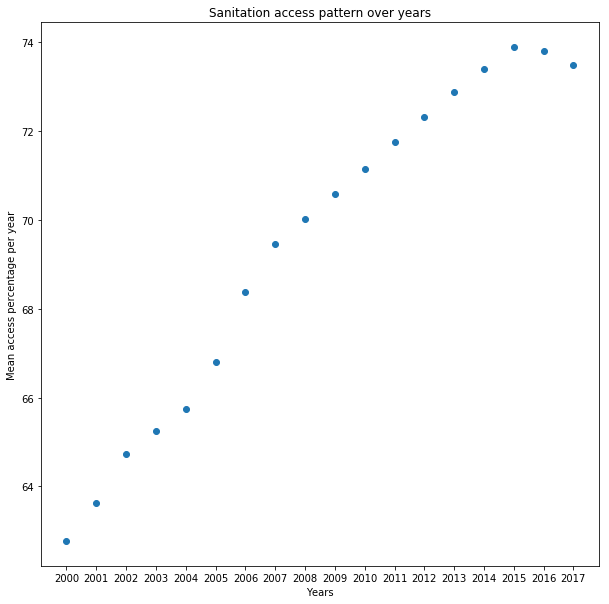

In [239]:
# now drawing the plot, resizing this was by the help of https://stackoverflow.com/questions/48429156/how-to-resize-matplotlib-scatter-plot
plt.figure(figsize=(10,10))
plt.scatter(sanitationc.columns[1:], sanitationm)
plt.title('Sanitation access pattern over years')
plt.xlabel('Years')
plt.ylabel('Mean access percentage per year')



### Question 2: how does each set change with sanitation?
We ask this question to see whether better sanitation reflects positively on the chosen parameters. If so, to what extent?

In [240]:
childm = mean_list(childc)


In [241]:
childm

[58.018540540540542,
 55.896864864864853,
 53.678972972972979,
 51.539081081081079,
 49.560432432432435,
 47.402918918918921,
 45.419945945945962,
 43.509297297297302,
 41.786702702702705,
 39.927945945945943,
 38.877243243243242,
 36.654270270270267,
 35.209783783783784,
 33.883351351351351,
 32.681243243243244,
 31.557567567567567,
 30.501081081081086,
 29.481675675675678]

Text(0,0.5,'Mean of child mortality/1000 per year')

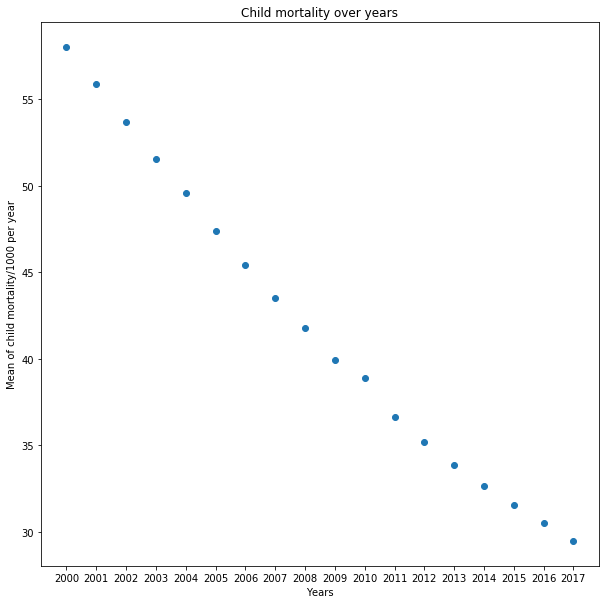

In [242]:
plt.figure(figsize=(10,10))
plt.scatter(male.columns[1:], childm)
plt.title('Child mortality over years')
plt.xlabel('Years')
plt.ylabel('Mean of child mortality/1000 per year')

In [243]:
malem = mean_list(malec)


In [244]:
malem

[63.937297297297306,
 64.224324324324328,
 64.523783783783784,
 64.838918918918921,
 65.169729729729724,
 65.511351351351351,
 65.874054054054056,
 66.248648648648654,
 66.62864864864865,
 67.018378378378372,
 67.401081081081088,
 67.776756756756754,
 68.138378378378377,
 68.481081081081086,
 68.80594594594595,
 69.107567567567571,
 69.377837837837845,
 69.631891891891897]

Text(0,0.5,'Mean of male expectancy per year')

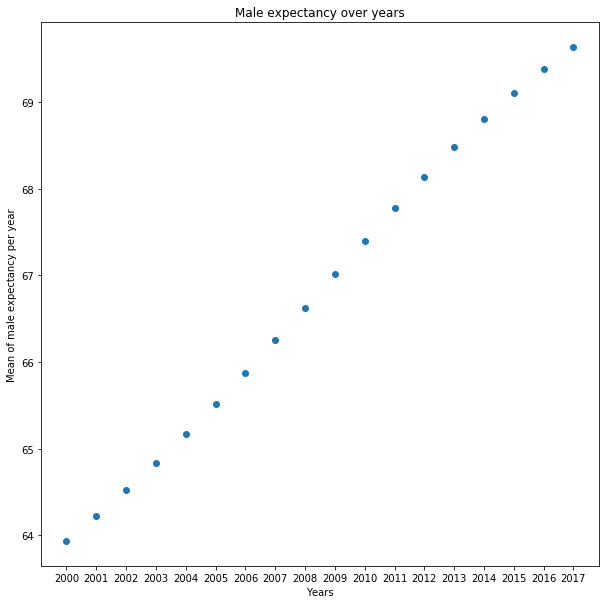

In [245]:
plt.figure(figsize=(10,10))
plt.scatter(male.columns[1:], malem)
plt.title('Male expectancy over years')
plt.xlabel('Years')
plt.ylabel('Mean of male expectancy per year')

In [246]:
femalem = mean_list(femalec)


In [247]:
femalem

[68.836756756756756,
 69.094054054054055,
 69.371891891891892,
 69.671351351351362,
 69.993513513513506,
 70.335675675675674,
 70.698378378378379,
 71.076216216216224,
 71.461081081081076,
 71.851891891891881,
 72.229729729729726,
 72.605405405405406,
 72.966486486486488,
 73.309189189189183,
 73.63513513513513,
 73.930810810810812,
 74.20756756756758,
 74.450810810810808]

Text(0,0.5,'Mean of female expectancy per year')

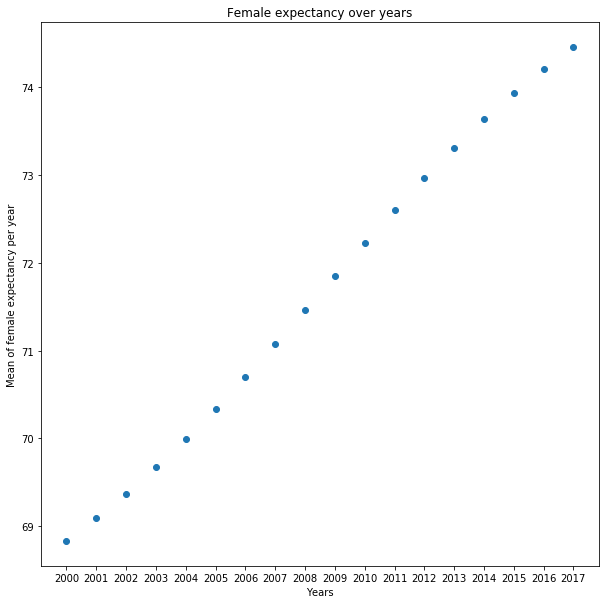

In [248]:
plt.figure(figsize=(10,10))
plt.scatter(male.columns[1:], femalem)
plt.title('Female expectancy over years')
plt.xlabel('Years')
plt.ylabel('Mean of female expectancy per year')

### Question 3: how does difference between male and female expectancy go?
This is meant to understand whether there are significant differences between sanitation impact on m and f expectancies.

In [249]:
diff = []
for i in range(len(malem)):
    diff.append(malem[i]- femalem[i])

In [250]:
diff

[-4.8994594594594503,
 -4.8697297297297268,
 -4.8481081081081072,
 -4.8324324324324408,
 -4.8237837837837816,
 -4.8243243243243228,
 -4.8243243243243228,
 -4.82756756756757,
 -4.8324324324324266,
 -4.833513513513509,
 -4.8286486486486382,
 -4.8286486486486524,
 -4.8281081081081112,
 -4.828108108108097,
 -4.8291891891891794,
 -4.8232432432432404,
 -4.8297297297297348,
 -4.8189189189189108]

Text(0,0.5,'Mean difference per year')

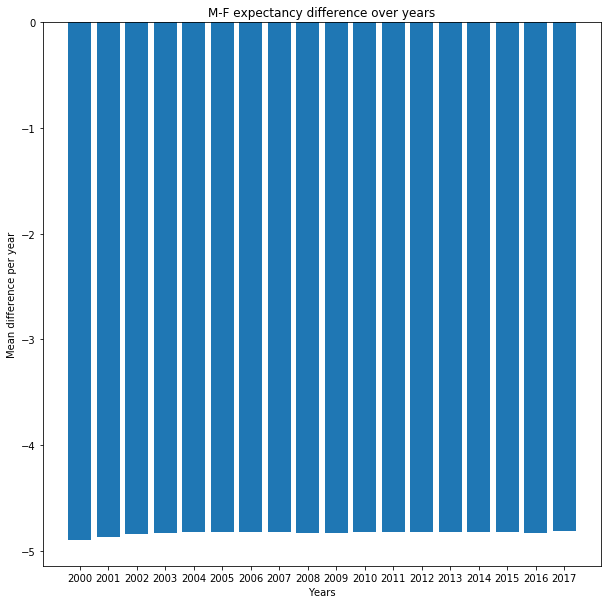

In [251]:
plt.figure(figsize=(10,10))
plt.bar(male.columns[1:], diff)
plt.title('M-F expectancy difference over years')
plt.xlabel('Years')
plt.ylabel('Mean difference per year')


<a id='conclusions'></a>
## Conclusions




### Question 1: how does sanitation change over the years?
We found the mean access to increase from about 63 in 2000 to about 74 in 2015. Then there was a slight drop in 2016 and 2017. 

### Question 2:how does each set change with sanitation? 
#### 1- There is a very clear drop in child mortality from 58 to 30
#### 2- Male expectancy clearly increases from 63 to 69
#### 3- Female expectancy clearly increases from 69 to 74

This means that there is a positive correlation between access to sanitation and health parameters.

### Question 3: how does each set change with sanitation?how does difference between male and female expectancy go?
There is no significant effect on the expectancy difference. It's practically constant at -4.8, which is likely due to the similar positive effect of sanitataion on both.

### Thus, the final conclusion is that better sanitaion, as expected, correlates positively with male and female expectancy, and negatively with child mortality. Therefore, it is likely that sanitation has a positive effect on a healthier life, and a protective effect from diseases that could cause child mortality.

## Limitations
The previous conclusions could be undermined by some limitations including:
- NaN values in sanitation dataset. Replacing them by zeros could impact the obtained means. However, they are few and also affect all correspondences equally. 
- Analysis was according to years, so the changes for each individual country cannot be measured. 

In [252]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0